## Binomial Image Classifier - part 2
### Using a pretrained convolutional neural network - ConvNet, CNN
A common and highly effective approach to deep learning on small image datasets is to use a pretrained network, which has previously been trainned on a large-scale image-classification task. If the original dataset is large and general enough, its features can prove useful for many different computervision problems.<br>
Here I'm using the **VGG16** architecture developed by Karen Simonyan and Andrew Zisserman in 2014, https://arxiv.org/abs/1409.1556 
It's simple and widely used although older than many newer state-of-the-art models, like ResNet, Inception and YOLO.<br><br>
The original source code is from Francois Chollet's book "Deep Learning with Python". I had to make a few tweaks to it to make it work with my slightly adjusted dataset. Furthermore I've added more comments for pedagogical reasons. https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438<br><br>
Here some samples of the used image dataset of 9000 cats and 9000 dogs.

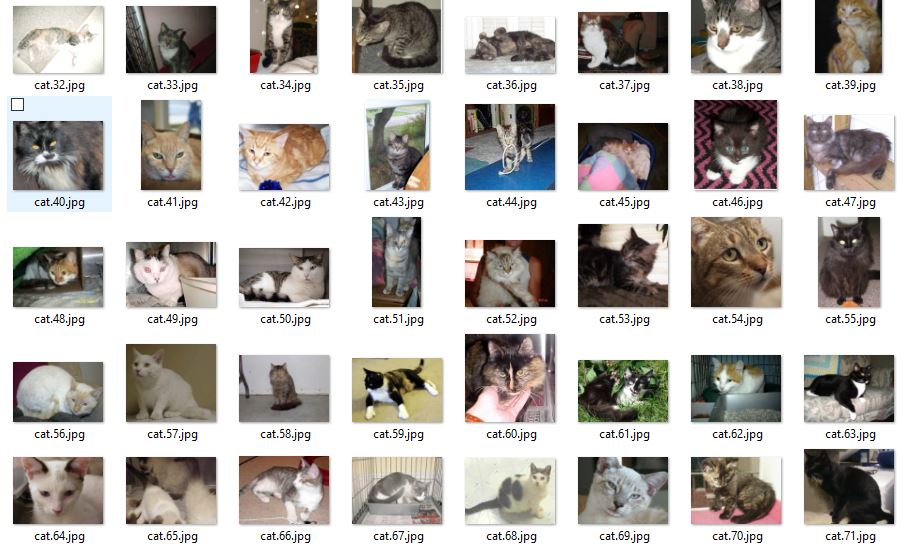

In [2]:
from IPython.display import Image
Image(filename="C:/Users/jangn/CODE/Sundog_DataScience/DataScience/DataScience-Python3/DeepLearning/DeepLearning_Keras/ConvNet basics/Training a ConvNet from scratch/cats.JPG" ,width=600, height= 200)

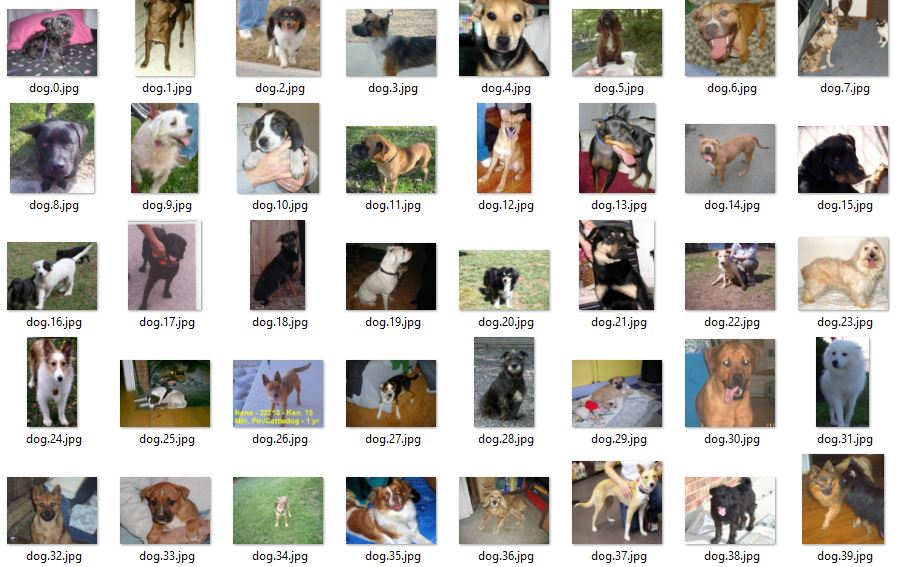

In [3]:
Image(filename="C:/Users/jangn/CODE/Sundog_DataScience/DataScience/DataScience-Python3/DeepLearning/DeepLearning_Keras/ConvNet basics/Training a ConvNet from scratch/dogs.JPG" ,width=600, height= 200)

### Instantiating the VGG16 convolutional base

Three arguments are passed to the constructor:
- **weights="imagenet"** Specifies the weight checkpoint from which to initialize the model: VGG16 was trained onImageNet
- **include_top = False** Refers to the densely connected classifier in the VGG16 model corresponding to the 1000 classes from ImageNet. Since my model only uses two classes, cats and dogs, this is not needed.
- **input_shape = (150, 150, 3)** The shape of the image tensors fed to the network. Optimal; if not added, network is still able to process inpus of any size.

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights="imagenet", include_top = False, input_shape = (150, 150, 3)) 

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step


### Extracting features using the pretrained convolutional base
The ImageDataGenerator extracts images as Numpy arrays as well as their labels. The features from the images are extracted by calling the *predict* method of the *conv_base* model. 

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#path to directory where the original dataset was uncompressed
original_dataset_dir = "/floyd/input/catsanddogs_12500/Dataset/"

base_dir = "/floyd/home/cats_and_dogs_SMALL"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                          target_size=(150, 150),
                                          batch_size=batch_size,
                                          class_mode = "binary")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # Needed since generators yield data indefinitely in a loop. This breaks loop after every image has been seen once.
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). They will be fed to a densely connected classifier, so they must first be flattened to (samples, 8192)

In [3]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

Now, a densely connected classifier can be defined, using drop-out for regularization, and train it on the data and lables recorded above.

In [4]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation="relu", input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation= "sigmoid"))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
          loss= "binary_crossentropy",
          metrics=["acc"])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.6020 - acc: 0.6675 - val_loss: 0.4329 - val_acc: 0.8520
Epoch 2/30
2000/2000 [==============================] - 1s 308us/step - loss: 0.4281 - acc: 0.8155 - val_loss: 0.3604 - val_acc: 0.8690
Epoch 3/30
2000/2000 [==============================] - 1s 301us/step - loss: 0.3533 - acc: 0.8550 - val_loss: 0.3284 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 1s 294us/step - loss: 0.3124 - acc: 0.8730 - val_loss: 0.3158 - val_acc: 0.8760
Epoch 5/30
2000/2000 [==============================] - 1s 287us/step - loss: 0.2947 - acc: 0.8695 - val_loss: 0.2909 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 293us/step - loss: 0.2635 - acc: 0.8985 - val_loss: 0.2758 - val_acc: 0.8970
Epoch 7/30
2000/2000 [==============================] - 1s 287us/step - loss: 0.2556 - acc: 0.9005 - val_loss: 0.2675 - val_acc: 0.8960
E

Training is very fast, because only two Dense layers need to be dealt with.
### Plotting the results

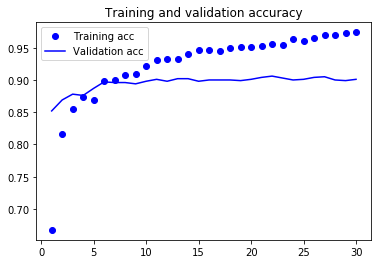

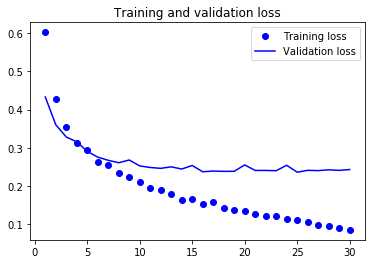

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

acc= history.history["acc"]
val_acc= history.history["val_acc"]
loss= history.history["loss"]
val_loss= history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label= "Training acc")
plt.plot(epochs, val_acc, "b", label= "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label= "Training loss")
plt.plot(epochs, val_loss, "b", label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Using a pretrained ConvNet reaches a validation accuracy of about 90%, which is much better than a small model trained from scratch, where the same dataset reaches around 75% without data augmentation. But the plots also show the model is still overfitting a little. This can be seen by the gap between the training and validation curves.  
### Feature extraction with data augmentation
By extending the c model and adding it end to end on the inputs allows you to use data augmentation during training. This technique is very "expensive" and shouldn't be run unless you have access to a GPU.<br>
Since models behave like layers one can be added (like *conv_base* here) to a *Sequential* model, just like adding another layer!


In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation= "relu"))
model.add(layers.Dense(1, activation= "sigmoid"))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


The covolutional base of VGG16 has 14.714.688 parameters, which is very large indeed! The classifier adding on top has c. 2 million parameters.<br>
Next, before compiling and training the model, it's very important to freeze the convolutional base. This prevents their weights from being updated during the training. If you don't do this, then the presentations that were previously learned by the convolutional base will be modified during the training! Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. With this setup, only the weights from the two *Dense* layers will be trained

#### Training the model end to end with a frozen convolutional base

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 40,                                  
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                   zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode= "nearest") 

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode="binary")

validation_generator=test_datagen.flow_from_directory(validation_dir,
                                                      target_size=(150,150),
                                                      batch_size=20,
                                                      class_mode="binary")

model.compile(loss= "binary_crossentropy",
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=["acc"])

history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 45s 452ms/step - loss: 0.4788 - acc: 0.7495 - val_loss: 0.1803 - val_acc: 0.9210
Epoch 2/30
100/100 [==============================] - 42s 417ms/step - loss: 0.2789 - acc: 0.8760 - val_loss: 0.2271 - val_acc: 0.9120
Epoch 3/30
100/100 [==============================] - 42s 419ms/step - loss: 0.1984 - acc: 0.9165 - val_loss: 0.1032 - val_acc: 0.9590
Epoch 4/30
100/100 [==============================] - 42s 419ms/step - loss: 0.1894 - acc: 0.9190 - val_loss: 0.1034 - val_acc: 0.9550
Epoch 5/30
100/100 [==============================] - 42s 419ms/step - loss: 0.1386 - acc: 0.9425 - val_loss: 0.1120 - val_acc: 0.9600
Epoch 6/30
100/100 [==============================] - 42s 418ms/step - loss: 0.1329 - acc: 0.9500 - val_loss: 0.0999 - val_acc: 0.9650
Epoch 7/30
100/100 [==============================] - 42s 419ms/step - loss: 0.1128 - acc: 0.9570 - val_lo

And plotting the results.

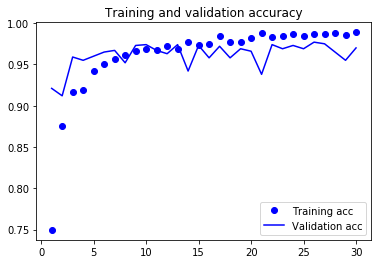

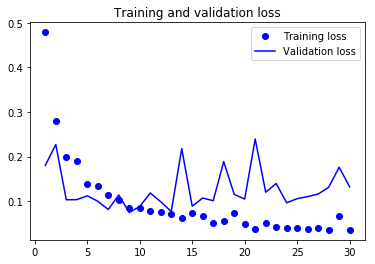

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

acc= history.history["acc"]
val_acc= history.history["val_acc"]
loss= history.history["loss"]
val_loss= history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label= "Training acc")
plt.plot(epochs, val_acc, "b", label= "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label= "Training loss")
plt.plot(epochs, val_loss, "b", label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

A validation accuracy of closer to 97% is received, which is much better than what could be achieved with the small binominal classifier ConvNet trained from scratch.

### Fine-tuning
Another technique than data augmentation to improve the model is fine-tuning. It is not as computationally expensive and consists of unfreezing a few of the top layers of a frozen model base used for feature extraction above. the steps fro fine-tuning a network are as follows
1. Add your custom network on top of an already-trained base network
2. Freeze the base network
3. Train the part you added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part you added


#### Freezing all layers up to a specific one

In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    

#### Fine-tuning the model
Using the RMSProp optimizer with a very low learning rate. I cut the number of epochs from 100 originally used by Francois Chollet in his book "Deel Learning with Python", from which the model is, to 30. 

In [13]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
          loss= "binary_crossentropy",
          metrics=["acc"])

history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, # changed from original 100 epochs to 30
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 28s 283ms/step - loss: 0.0088 - acc: 0.9980 - val_loss: 0.1271 - val_acc: 0.9770
Epoch 2/30
100/100 [==============================] - 26s 256ms/step - loss: 0.0084 - acc: 0.9970 - val_loss: 0.1579 - val_acc: 0.9730
Epoch 3/30
100/100 [==============================] - 26s 255ms/step - loss: 0.0142 - acc: 0.9970 - val_loss: 0.1309 - val_acc: 0.9740
Epoch 4/30
100/100 [==============================] - 26s 256ms/step - loss: 0.0108 - acc: 0.9975 - val_loss: 0.1219 - val_acc: 0.9780
Epoch 5/30
100/100 [==============================] - 26s 258ms/step - loss: 0.0103 - acc: 0.9965 - val_loss: 0.1541 - val_acc: 0.9740
Epoch 6/30
100/100 [==============================] - 25s 254ms/step - loss: 0.0147 - acc: 0.9955 - val_loss: 0.1298 - val_acc: 0.9780
Epoch 7/30
100/100 [==============================] - 25s 252ms/step - loss: 0.0035 - acc: 0.9985 - val_loss: 0.1331 - val_acc: 0.9760
Epoch 8/30
100/100 [==============================] - 2

And plotting the results.

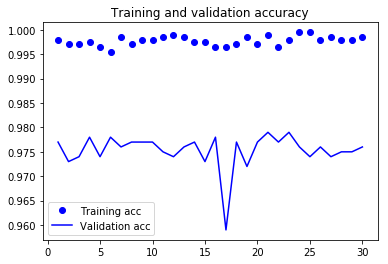

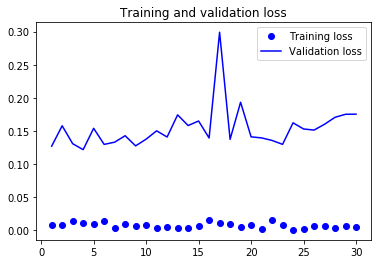

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

acc= history.history["acc"]
val_acc= history.history["val_acc"]
loss= history.history["loss"]
val_loss= history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label= "Training acc")
plt.plot(epochs, val_acc, "b", label= "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label= "Training loss")
plt.plot(epochs, val_loss, "b", label= "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

The validation accuracy was further improved to closer to 98%. And this only with a training set of 2.000!. This makes a point that even with smaller samples, here 2000, high accuracy can be achived using various techniques.